In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'


Reading in the Consensus PFAS Universe file

In [3]:
universe = pd.read_excel(interim_dir+'PFAS Universe 2021-08-25.xlsx')

In [4]:
universe.head()

,dtxsid,casrn,name,smiles,formula,nc,mw,vp,volatile,nickname,...,PFAS 54,PFAS NAM All,list_count,acute,subchronic,chronic,devtox,reprotox,neurotox,immunotox
0,DTXSID7029904,678-39-7,Fluorotelomer alcohol 8:2,OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,C10H5F17O,10,464.122,2.070880e-01,F,8:2 FTOH,...,NaN,1.0,2,1,12,0,5,0,0,0
1,DTXSID3037707,29420-49-3,Potassium perfluorobutanesulfonate,[K+].[O-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,C4F9KO3S,4,338.180,1.136250e-08,F,KPFBS,...,NaN,1.0,2,4,10,3,3,5,0,0
2,DTXSID5044572,647-42-7,"3,3,4,4,5,5,6,6,7,7,8,8,8-Tridecafluorooctanol",OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,C8H5F13O,8,364.106,6.011380e-01,F,6:2 FTOH,...,NaN,1.0,2,3,10,1,4,9,0,0
3,DTXSID6047575,19430-93-4,"3,3,4,4,5,5,6,6,6-Nonafluorohexene",FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C=C,C6H3F9,6,246.076,2.135170e+03,T,"3,3,4,4,5,5,6,6,6-Nonafluorohexene",...,NaN,1.0,2,3,9,3,6,0,0,0
4,DTXSID0061826,1623-05-8,Perfluoropropyl trifluorovinyl ether,FC(F)=C(F)OC(F)(F)C(F)(F)C(F)(F)F,C5F10O,5,266.038,2.130420e+02,T,PPVE,...,1.0,1.0,3,5,8,2,4,0,0,0


In [5]:
universe['vp'].isnull().sum()

54

In [6]:
universe = universe[universe['vp'].notnull()]

In [7]:
def subcategory(row):
    if row['volatile'] == 'T':
        return 'volatile'
    elif row['nc'] >= 8:
        return 'gte8'
    else:
        return 'lt8'

In [8]:
universe['subcategory'] = universe.apply(lambda row: subcategory(row), axis =1)

In [9]:
universe.groupby(['category', 'subcategory']).size().sort_values(ascending = False)

category                       subcategory
Others                         gte8           1927
                               volatile        775
                               lt8             656
PFAA precursors                gte8            597
unclassified                   gte8            503
Fluorotelomer PFAA precursors  gte8            343
PFAA precursors                lt8             253
PFAAs                          gte8            222
Others, cyclic                 gte8            213
PFAAs                          lt8             129
Non-PFAA perfluoroalkyls       volatile        125
Others, cyclic                 volatile        118
FASA based PFAA precursors     gte8            114
PFAA precursors                volatile        111
Others, cyclic                 lt8              86
Fluorotelomer PFAA precursors  volatile         57
Non-PFAA perfluoroalkyls       gte8             55
unclassified                   lt8              51
Fluorotelomer PFAA precursors  lt8     

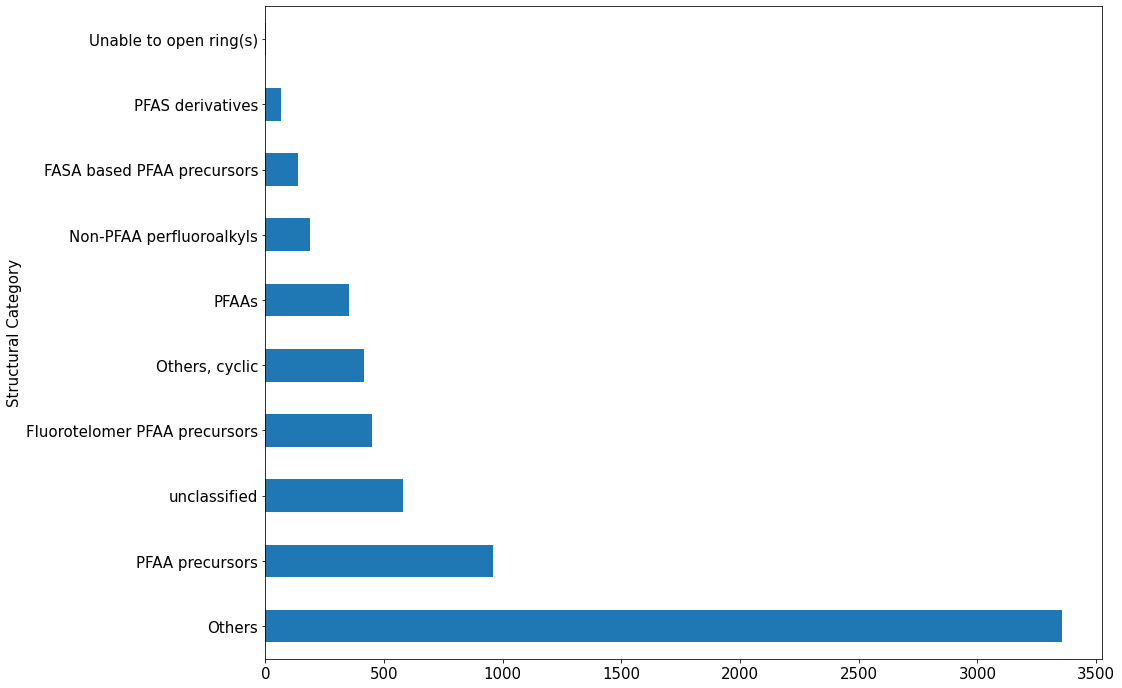

In [11]:
universe.category.value_counts().plot.barh(figsize = (15,12), fontsize = 15, legend = False)
plt.ylabel('Structural Category' ,fontsize = 15)
plt.savefig(figures_dir+'frequency_categories_pfas_universe_161121.png', dpi = 300, bbox_inches='tight');

In [53]:
list_index_order = universe.category.value_counts().reset_index()['index'].tolist()[::-1]

In [15]:
#universe.to_csv(interim_dir+'pfas6504_4TxPs_161121.csv')

In [10]:
def txp_categories(text_file):
    df = pd.read_csv(text_file, sep = ';')
    df.rename(columns = {'M_NAME': 'DTXSID'},inplace = True)
    df = df.set_index('DTXSID')
    df.drop(['M_COMPOUND_HISTORY_[STRING]','M_CORINA_SYMPHONY_ERRORS_[STRING]'],axis = 1, inplace = True)
    test_rev = []
    for i, row in df.iterrows():
        if (row['bond:C=O_carbonyl_generic'] == 1 ) & (row['bond:CC(=O)C_ketone_aliphatic_generic'] == 1):
            test_rev.append([i,'TxP_PFAS_ketone'])
        if (row['bond:C(=O)O_carboxylicEster_alkenyl'] == 1) & (row['bond:C(=O)O_carboxylicEster_acyclic'] == 1) &  (row['chain:alkeneLinear_mono-ene_ethylene_generic'] ==1) & (row['bond:C=O_carbonyl_generic'] ==1 ):
            test_rev.append([i,'TxP_PFAS_acrylate'])
        if (row['bond:COH_alcohol_aliphatic_generic'] == 1) & (row['bond:COH_alcohol_generic'] ==1):
            test_rev.append([i, 'TxP_PFAS_alcohol'])
        if (row['bond:COH_alcohol_aliphatic_generic'] == 1) & (row['bond:COH_alcohol_generic'] ==1) & (row['bond:COH_alcohol_pri-alkyl'] == 1):
            test_rev.append([i,'TxP_PFAS_alcohol_primary']) 
        if (row['bond:COH_alcohol_aliphatic_generic'] == 1) & (row['bond:COH_alcohol_generic'] ==1) & (row['bond:COH_alcohol_pri-alkyl'] == 1) & (row['bond:COH_alcohol_sec-alkyl'] ==1):
            test_rev.append([i,'TxP_PFAS_alcohol_primary_FT_diol']) 
        if (row['bond:COH_alcohol_aliphatic_generic'] == 1) & (row['bond:COH_alcohol_generic'] ==1) & (row['bond:COH_alcohol_pri-alkyl'] == 1) & (row['bond:C(~Z)~C~Q_a-haloalcohol'] ==1):
            test_rev.append([i,'TxP_PFAS_alcohol_primary_FTn1']) 
        if (row['bond:COH_alcohol_aliphatic_generic'] == 1) & (row['bond:COH_alcohol_generic'] ==1) & (row['bond:COH_alcohol_pri-alkyl'] == 1) & (row['chain:alkaneLinear_propyl_C3'] ==1) & (row['chain:alkaneLinear_ethyl_C2(H_gt_1)'] == 1):
            test_rev.append([i,'TxP_PFAS_alcohol_primary_FTn2'])
        if (row['bond:COH_alcohol_aliphatic_generic'] == 1) & (row['bond:COH_alcohol_generic'] ==1) & (row['bond:C(~Z)~C~Q_a-haloalcohol'] == 1) & (row['bond:COH_alcohol_pri-alkyl'] == 0):
            test_rev.append([i,'TxP_PFAS_alcohol_polyF']) 
        if (row['bond:COH_alcohol_aliphatic_generic'] == 1) & (row['bond:COH_alcohol_generic'] ==1) & (row['bond:S(=O)N_sulfonylamide'] ==1):
            test_rev.append([i,'TxP_PFAS_alcohol_sulfonylamide']) 
        if (row['bond:CN_amine_aliphatic_generic'] ==1):
            test_rev.append([i,'TxP_PFAS_amine']) 
        if (row['bond:CN_amine_aliphatic_generic'] ==1) & (row['bond:COC_ether_aliphatic'] ==1):
            test_rev.append([i,'TxP_PFAS_amine_ether']) 
        if (row['bond:CN_amine_aliphatic_generic'] ==1) & (row['bond:CN_amine_pri-NH2_alkyl'] ==1):
            test_rev.append([i,'TxP_PFAS_amine_primary']) 
        if (row['bond:C(=O)O_carboxylicAcid_generic'] ==1):
            test_rev.append([i,'TxP_PFAS_COOH']) 
        if (row['bond:C(=O)O_carboxylicAcid_generic'] ==1) & (row['bond:COC_ether_aliphatic'] ==1):
            test_rev.append([i,'TxP_PFAS_COOH_ether']) 
        if (row['bond:C(=O)O_carboxylicAcid_generic'] ==1) & (row['chain:alkeneLinear_mono-ene_ethylene_generic'] ==1):
            test_rev.append([i,'TxP_PFAS_COOH_ethylene']) 
        if (row['bond:C(=O)O_carboxylicAcid_generic'] ==1) & (row['bond:C(=O)O_carboxylicAcid_alkyl'] ==1) & (row['chain:alkaneLinear_ethyl_C2(H_gt_1)'] ==1) & (row['chain:alkaneLinear_propyl_C3'] ==1) & (row['chain:alkaneLinear_ethyl_C2_(connect_noZ_CN=4)'] ==1):
            test_rev.append([i,'TxP_PFAS_COOH_FT'])
        if (row['bond:C(=O)O_carboxylicEster_acyclic'] ==1) & (row['bond:C(=O)O_carboxylicEster_alkyl'] ==1) & (row['bond:C=O_carbonyl_generic'] ==1):
            test_rev.append([i,'TxP_PFAS_COOR']) 

        if (row['bond:S=O_sulfonyl_generic'] ==1):
            test_rev.append([i,'TxP_PFAS_sulfonyl']) 
        if (row['bond:S=O_sulfonyl_generic'] ==1) & (row['bond:S(=O)N_sulfonylamide'] == 1):   
            test_rev.append([i,'TxP_PFAS_sulfonamide'])
        if (row['bond:S=O_sulfonyl_generic'] == 1) & (row['bond:S(=O)N_sulfonylamide'] == 1) & (row['bond:COH_alcohol_generic'] ==1):
            test_rev.append([i,'TxP_PFAS_sulfonamide_alcohol'])
        if (row['bond:S(=O)O_sulfonicAcid_generic'] == 1) & (row['bond:S(=O)O_sulfonate'] == 1) & (row['bond:S(=O)O_sulfonicAcid_acyclic_(chain)'] == 1):
            test_rev.append([i,'TxP_PFAS_sulfonate']) 
        if (row['bond:S(=O)O_sulfonicAcid_generic'] == 1) & (row['bond:S(=O)O_sulfonate'] == 1) & (row['bond:S(=O)O_sulfonicAcid_acyclic_(chain)'] == 1) & (row['chain:alkaneLinear_ethyl_C2(H_gt_1)'] == 1) & (row['chain:alkaneLinear_propyl_C3'] == 1):   
            test_rev.append([i,'TxP_PFAS_sulfonate_FTn2'])
        if (row['bond:S=O_sulfonyl_generic'] ==1) & (row['bond:S(=O)X_sulfonylhalide'] ==1):
            test_rev.append([i,'TxP_PFAS_sulfonylhalide']) 
        if (row['bond:COC_ether_aliphatic'] ==1):
            test_rev.append([i,'TxP_PFAS_ether']) 
        if (row['bond:metal_metalloid_Si_organo'] ==1):
            test_rev.append([i,'TxP_PFAS_silane'])
        if (row['bond:C(=O)N_carboxamide_generic'] ==1):
            test_rev.append([i,'TxP_PFAS_carboxamide'])
        if (row['bond:C=O_acyl_halide'] ==1):
            test_rev.append([i,'TxP_PFAS_acylhalide'])
        if (row['bond:OZ_oxide_hyroxy'] ==1):
            test_rev.append([i,'TxP_PFAS_oxidehydroxy'])
        if (row['bond:CX_halide_alkyl-F_perfluoro_hexyl'] == 1) & (row['bond:CX_halide_alkyl-F_perfluoro_octyl'] == 0):
            test_rev.append([i,'TxP_PFAS_perFhexyl'])
        if (row['bond:CX_halide_alkyl-F_perfluoro_octyl'] == 1):
            test_rev.append([i,'TxP_PFAS_perFoctyl']) 
        if (row['bond:CX_halide_alkyl-X_primary'] == 1):
            test_rev.append([i,'TxP_PFAS_alkylXprimary'])
        if (row['bond:CX_halide_alkyl-X_tertiary'] == 1) & (row['bond:C=O_carbonyl_generic'] == 0): 
            test_rev.append([i, 'TxP_PFAS_alkylXtertiaryxCO']) 
        if (row['chain:alkeneLinear_mono-ene_ethylene_generic'] == 1) & (row['bond:C=O_carbonyl_generic'] == 0): 
            test_rev.append([i, 'TxP_PFAS_ethylene_xCO'])
        if (row['bond:C=O_carbonyl_generic'] == 1) & (row['bond:C(=O)N_carboxamide_generic'] == 0) & (row['bond:C(=O)O_carboxylicAcid_generic'] == 0) & (row['bond:C(=O)O_carboxylicEster_alkenyl'] == 0) & (row['bond:C(=O)O_carboxylicEster_alkyl'] == 0) & (row['bond:C=O_acyl_halide'] == 0) & (row['bond:CC(=O)C_ketone_aliphatic_generic'] == 0): 
            test_rev.append([i,'TxP_PFAS_aldehydeanhydride'])
    return pd.DataFrame(test_rev, columns = ['DTXSID', 'Txp_cats'])       

In [11]:
universe_txps = txp_categories(interim_dir+'OPSCPP_4TxPs_res.txt')

In [12]:
#from sklearn.preprocessing import OneHotEncoder

In [13]:
#enc = OneHotEncoder(handle_unknown='ignore')

In [14]:
universe_txps.set_index('DTXSID', inplace = True)

In [15]:
onehot = pd.get_dummies(universe_txps["Txp_cats"])

In [16]:
universe_txps_2 = pd.merge(universe_txps, onehot, on = universe_txps.index, how = 'left')

In [17]:
universe_txps_3 = universe_txps_2.groupby('key_0').max().reset_index()

In [18]:
universe_txps_3.drop(['Txp_cats'], axis = 1, inplace = True)

In [19]:
universe_txps_3.rename(columns = {'key_0': 'DTXSID'}, inplace = True)

In [20]:
universe_txps_3.rename(columns = {'DTXSID': 'dtxsid'}, inplace = True)

In [21]:

df2 = pd.merge(universe, universe_txps_3, on = 'dtxsid', how = 'left')

In [22]:
df2.columns.get_loc('TxP_PFAS_COOH')

27

In [23]:
df2.columns[27:]

Index(['TxP_PFAS_COOH', 'TxP_PFAS_COOH_FT', 'TxP_PFAS_COOH_ether',
       'TxP_PFAS_COOH_ethylene', 'TxP_PFAS_COOR', 'TxP_PFAS_acrylate',
       'TxP_PFAS_acylhalide', 'TxP_PFAS_alcohol', 'TxP_PFAS_alcohol_polyF',
       'TxP_PFAS_alcohol_primary', 'TxP_PFAS_alcohol_primary_FT_diol',
       'TxP_PFAS_alcohol_primary_FTn1', 'TxP_PFAS_alcohol_primary_FTn2',
       'TxP_PFAS_alcohol_sulfonylamide', 'TxP_PFAS_aldehydeanhydride',
       'TxP_PFAS_alkylXprimary', 'TxP_PFAS_alkylXtertiaryxCO',
       'TxP_PFAS_amine', 'TxP_PFAS_amine_ether', 'TxP_PFAS_amine_primary',
       'TxP_PFAS_carboxamide', 'TxP_PFAS_ether', 'TxP_PFAS_ethylene_xCO',
       'TxP_PFAS_ketone', 'TxP_PFAS_oxidehydroxy', 'TxP_PFAS_perFhexyl',
       'TxP_PFAS_perFoctyl', 'TxP_PFAS_silane', 'TxP_PFAS_sulfonamide',
       'TxP_PFAS_sulfonamide_alcohol', 'TxP_PFAS_sulfonate',
       'TxP_PFAS_sulfonate_FTn2', 'TxP_PFAS_sulfonyl',
       'TxP_PFAS_sulfonylhalide'],
      dtype='object')

In [33]:
hm_data = df2.groupby('category')[df2.columns[27:]].agg('sum').astype(int)

In [55]:
list_index_order

['Unable to open ring(s)',
 'PFAS derivatives',
 'FASA based PFAA precursors',
 'Non-PFAA perfluoroalkyls',
 'PFAAs',
 'Others, cyclic',
 'Fluorotelomer PFAA precursors',
 'unclassified',
 'PFAA precursors',
 'Others']

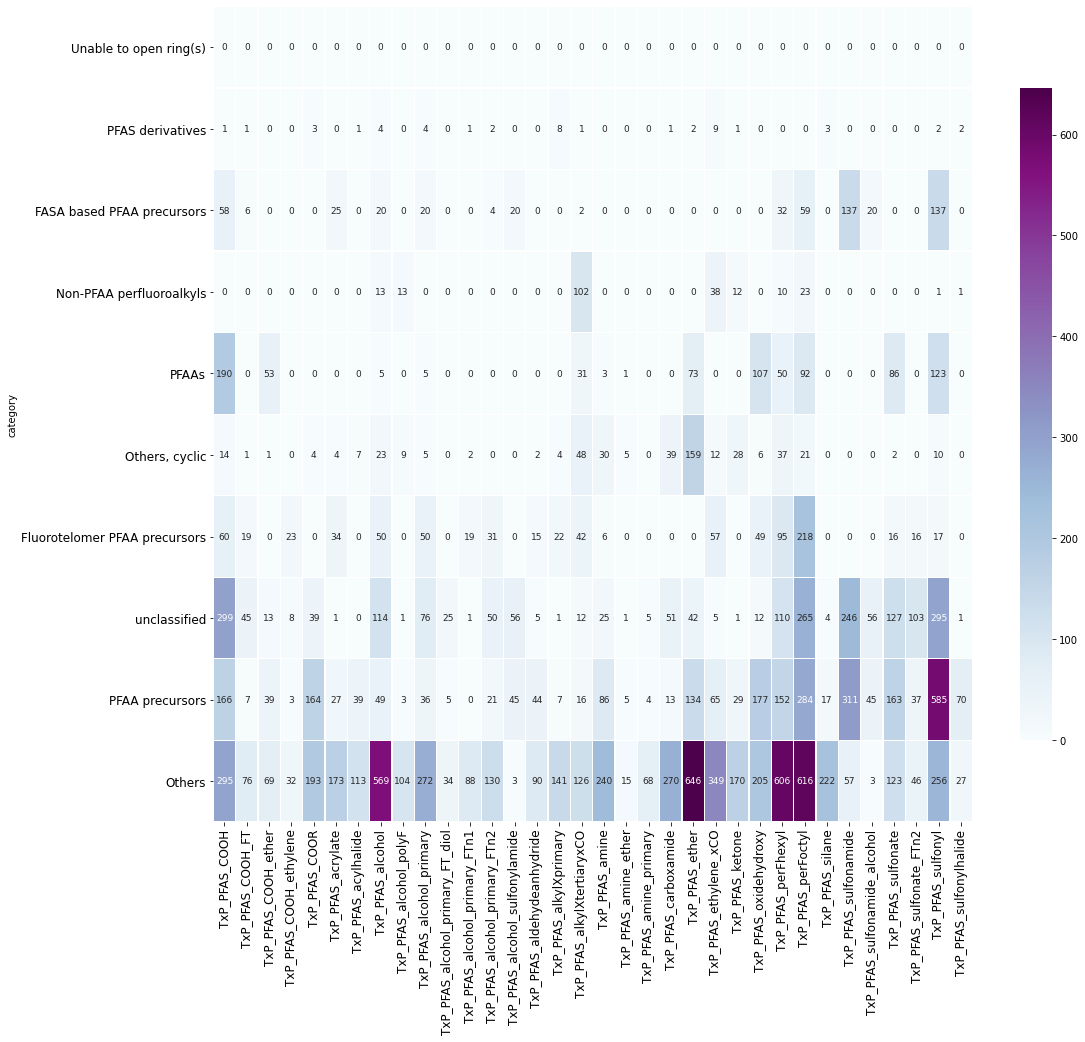

In [66]:
plt.figure(figsize = (17,15))
sns.heatmap(hm_data.reindex(list_index_order), annot = True, fmt = 'd',cmap = 'BuPu',linewidth=0.3,  annot_kws={"size": 9}, cbar_kws={"shrink": .8})
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);
plt.savefig(figures_dir+'oecd_vs_TxP_cats_PFASEPA_140422.png', dpi = 300, bbox_inches='tight');

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'FASA based PFAA precursors'),
  Text(0, 1.5, 'Fluorotelomer PFAA precursors'),
  Text(0, 2.5, 'Non-PFAA perfluoroalkyls'),
  Text(0, 3.5, 'Others'),
  Text(0, 4.5, 'Others, cyclic'),
  Text(0, 5.5, 'PFAA precursors'),
  Text(0, 6.5, 'PFAAs'),
  Text(0, 7.5, 'PFAS derivatives'),
  Text(0, 8.5, 'Unable to open ring(s)'),
  Text(0, 9.5, 'unclassified')])

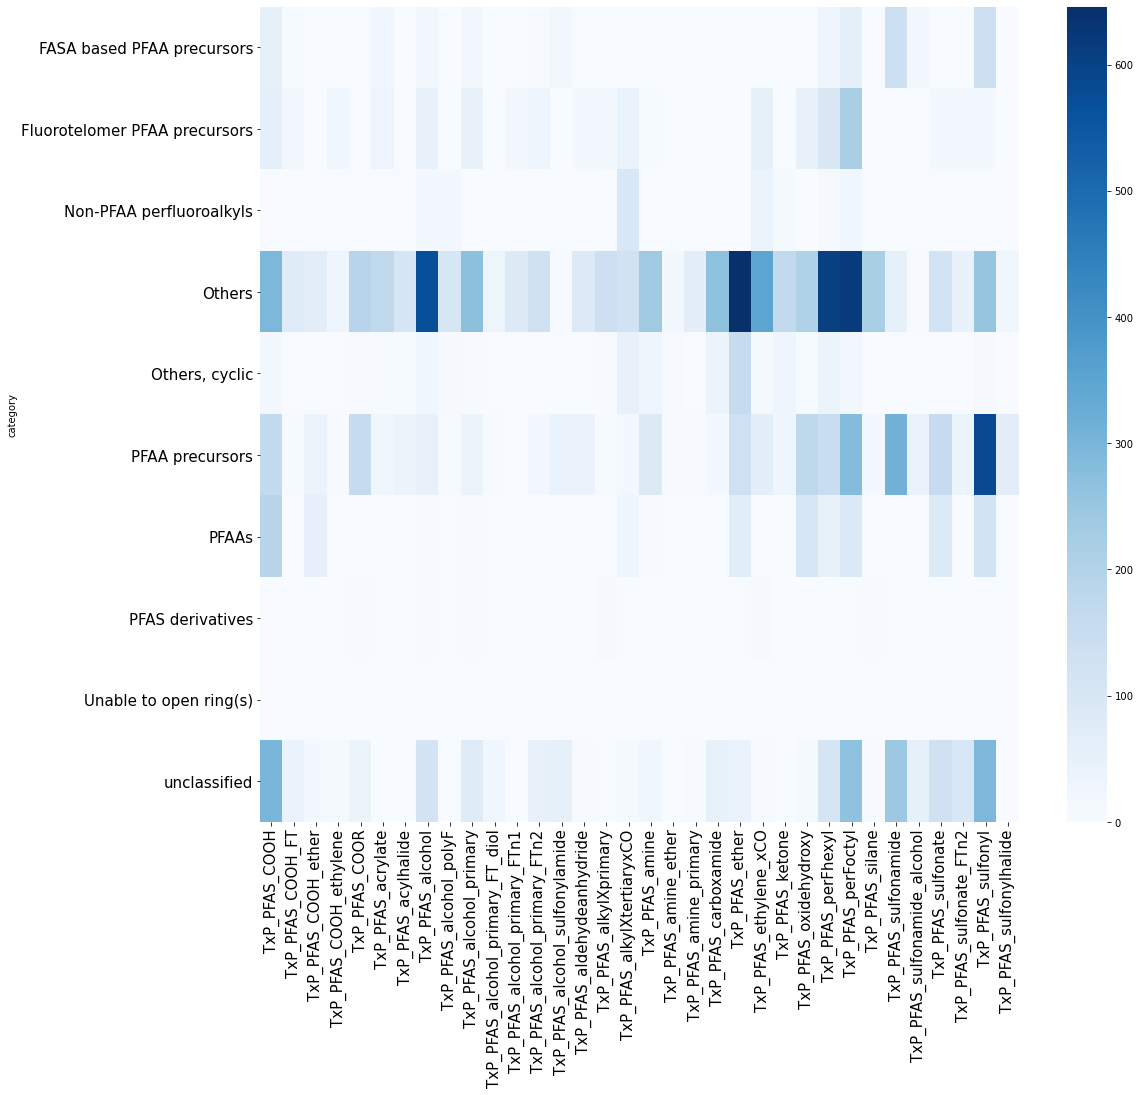

In [67]:
plt.figure(figsize = (17,15))
sns.heatmap(df2.groupby('category')[df2.columns[27:]].agg('sum').astype(int), annot = False, fmt = 'd',cmap = 'Blues', annot_kws={"size": 12})
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.savefig(figures_dir+'oecd_vs_TxP_cats_PFASEPA_161121.png', dpi = 300, bbox_inches='tight');

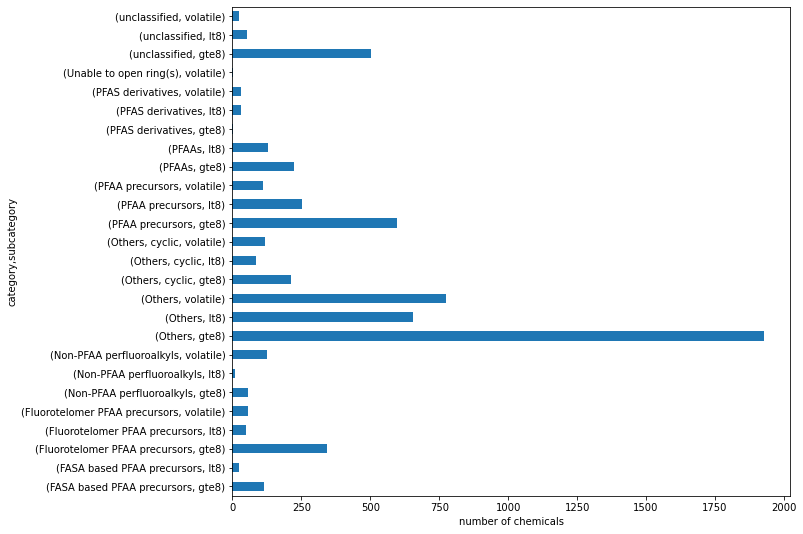

In [69]:
plt.figure(figsize = (10,9))
universe.groupby(['category', 'subcategory']).size().plot.barh()
plt.xlabel('number of chemicals')
plt.savefig(figures_dir+'frequency_categories_pfasepa_161121.png', dpi = 300, bbox_inches='tight');